In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df = pd.read_csv('clustering_data.csv')
df = df.drop(columns='loudness') ## drop loudness because it is highly correlated with energy

# Handle negative or NaN values before log transformation
for col in ['speechiness', 'instrumentalness', 'liveness']:
    df[col] = df[col].clip(lower=0).fillna(0)  # Replace NaN and negative values with 0
    df[f'{col}_log'] = np.log1p(df[col])  # log(1 + x)


# Features to use for clustering
clustering_features = ['danceability', 'energy', 'valence', 'tempo', 
                       'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']

# Select the features for clustering and drop NaN rows
X = df[clustering_features].dropna()

print("Data shape:", X.shape)
print("Features used for clustering:", clustering_features)



Data shape: (89740, 8)
Features used for clustering: ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']


## Sampling and Computing the Similarity Matrix

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

# Sample a smaller portion of the dataset
X_sample = X.sample(n=10000, random_state=42)  # Adjust n as needed

# Compute cosine similarity on the sample
similarity_matrix_sample = cosine_similarity(X_sample.values)


# Debugging similarity matrix properties
print("Similarity Matrix Shape:", similarity_matrix_sample.shape)
print("Is Symmetric:", np.allclose(similarity_matrix_sample, similarity_matrix_sample.T, atol=1e-8))
print("Contains Negative Values:", np.any(similarity_matrix_sample < 0))


Similarity Matrix Shape: (10000, 10000)
Is Symmetric: True
Contains Negative Values: True


### Cosine Similarity Matrix

In this step, we compute the **cosine similarity matrix** for a sample of 10,000 songs from the dataset. Cosine similarity measures how similar two vectors are, based on the cosine of the angle between them. It is often used in clustering tasks where feature vectors represent data points, such as songs with their musical characteristics.

- **Input:** The feature vectors for the sampled dataset (`X_sample`).
- **Output:** A 10,000 x 10,000 similarity matrix where each cell represents the cosine similarity between a pair of songs.

We check the properties of the similarity matrix to ensure it meets the requirements for Spectral Clustering:
1. **Shape:** The matrix has the correct dimensions: (10,000, 10,000).
2. **Symmetry:** The matrix is symmetric because cosine similarity between two songs is the same in both directions.
3. **Negative Values:** We'll clip any negative values in the matrix to ensure compatibility with Spectral Clustering, as it requires all values to be non-negative.

## Applying Spectral Clustering

In [33]:
from sklearn.cluster import SpectralClustering

# Set the number of clusters
n_clusters = 5


# Ensure diagonal is zero
np.fill_diagonal(similarity_matrix_sample, 0)

# Clip negative values (if any)
similarity_matrix_sample = np.clip(similarity_matrix_sample, 0, None)


# Initialize Spectral Clustering
spectral_cluster = SpectralClustering(
    n_clusters=n_clusters, 
    affinity='precomputed', 
    random_state=42
)

# Fit and predict labels
labels = spectral_cluster.fit_predict(similarity_matrix_sample)

# Add labels to the sampled DataFrame
X_sample['SpectralCluster'] = labels

# Check cluster distribution
print(X_sample['SpectralCluster'].value_counts())


SpectralCluster
3    2681
1    2419
0    1949
4    1547
2    1404
Name: count, dtype: int64


### Spectral Clustering Results

Using the precomputed cosine similarity matrix, we apply **Spectral Clustering** to group the sampled songs into 5 distinct clusters. Spectral Clustering is a graph-based clustering method that uses the similarity matrix to partition the data into groups.

- **Number of Clusters:** 5 (as chosen for this step).
- **Cluster Labels:** Each song is assigned to one of the clusters (labeled `0` through `4`).
- **Cluster Distribution:** The following cluster sizes were obtained:
  - Cluster 3: 2,681 songs
  - Cluster 1: 2,419 songs
  - Cluster 0: 1,949 songs
  - Cluster 4: 1,547 songs
  - Cluster 2: 1,404 songs

The output shows that the clustering process worked successfully, and each song has been grouped into one of the 5 clusters. The sizes of the clusters provide insight into how the data is distributed. Cluster 3 contains the largest number of songs, while Cluster 2 has the smallest.



## Analysis

In [34]:
# Group by Spectral Clusters to analyze features within each cluster
spectral_analysis = X_sample.groupby('SpectralCluster').mean()
print("Spectral Clustering Analysis:")
print(spectral_analysis)


Spectral Clustering Analysis:
                 danceability    energy   valence     tempo  acousticness  \
SpectralCluster                                                             
0                   -0.454007  0.558579  0.021497  1.328683     -0.513731   
1                   -0.521092 -1.278786 -0.520992 -0.413737      1.361331   
2                    0.906279  0.034304 -0.530736 -0.057631     -0.572037   
3                    0.789356  0.341932  1.148012 -0.204303     -0.189562   
4                   -0.727666  0.678830 -0.553871 -0.651605     -0.659082   

                 speechiness_log  instrumentalness_log  liveness_log  
SpectralCluster                                                       
0                       0.173362              0.154943      0.233715  
1                       0.078994              0.331329      0.151961  
2                       0.185336              0.341036      0.098074  
3                       0.171775              0.079667      0.194576  
4   

### Spectral Clustering Analysis

The table below summarizes the mean values of the key audio features for each spectral cluster. These mean values provide insights into the characteristics of each cluster, allowing us to understand the types of songs grouped together.

| **Feature**              | **Cluster 0** | **Cluster 1** | **Cluster 2** | **Cluster 3** | **Cluster 4** |
|--------------------------|---------------|---------------|---------------|---------------|---------------|
| **Danceability**         | -0.454        | -0.521        |  0.906        |  0.789        | -0.728        |
| **Energy**               |  0.559        | -1.279        |  0.034        |  0.342        |  0.679        |
| **Valence**              |  0.021        | -0.521        | -0.531        |  1.148        | -0.554        |
| **Tempo**                |  1.329        | -0.414        | -0.058        | -0.204        | -0.652        |
| **Acousticness**         | -0.514        |  1.361        | -0.572        | -0.190        | -0.659        |
| **Speechiness (Log)**    |  0.173        |  0.079        |  0.185        |  0.172        |  0.167        |
| **Instrumentalness (Log)** |  0.155        |  0.331        |  0.341        |  0.080        |  0.228        |
| **Liveness (Log)**       |  0.234        |  0.152        |  0.098        |  0.195        |  0.344        |

### **Cluster Interpretation**
1. **Cluster 0**: Songs with moderate energy, lower danceability, and high tempo, leaning towards tracks with a slight acoustic presence and moderate liveness.
2. **Cluster 1**: Calm and acoustic-heavy songs with low energy and valence, suggesting relaxing or somber tracks.
3. **Cluster 2**: Highly danceable tracks with moderate instrumentalness, suggesting energetic and vibrant music suitable for dance or workout playlists.
4. **Cluster 3**: High-valence tracks with strong danceability, leaning towards upbeat and cheerful music with low instrumental elements.
5. **Cluster 4**: Tracks with a mix of energy and acoustic elements but higher liveness, suggesting songs with live performance vibes.

### Key Insights
- **Cluster 3** appears to group the most upbeat and cheerful songs based on high valence and danceability.
- **Cluster 1** groups calm, relaxing songs with acoustic and instrumental characteristics.
- **Cluster 4** has the highest liveness score, indicating tracks with a live or ambient feel.
- These insights can be used to refine recommendation systems and suggest tracks based on user preferences for energy, mood, or instrumental qualities.


### Comparing Spectral Clustering with K-Means Clustering



#### Comparison with K-Means Clustering:
1. **Alignment**: 
   - Spectral Cluster 3 aligns with K-Means Cluster 0 (danceable pop/electronic).
   - Spectral Cluster 1 aligns with K-Means Cluster 1 (calm, acoustic).

2. **Differences**:
   - Spectral Clustering identifies hybrid traits (e.g., live performance in Cluster 4), offering subtler relationships compared to K-Means' distinct genre-based clusters.

3. **Interpretability**:
   - K-Means provides clearer genre-based clusters.
   - Spectral Clustering captures deeper, more nuanced track relationships.


### Conclusion:
Spectral Clustering complements K-Means by uncovering subtler connections, such as live-performance tracks or hybrid genres. Combining both methods enhances cluster analysis, allowing more refined recommendations based on user preferences.


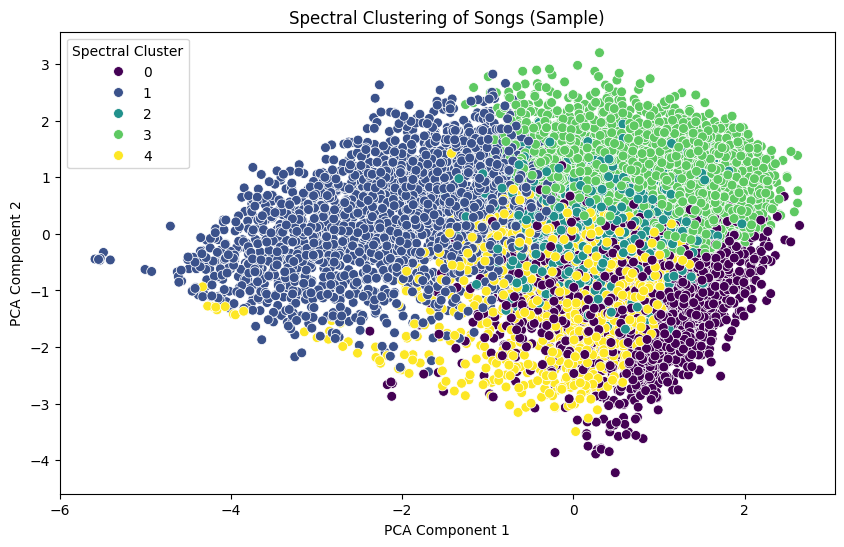

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample.drop(columns=['SpectralCluster'], errors='ignore'))

# Plot Spectral Clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_sample['SpectralCluster'], palette="viridis", s=50)
plt.title("Spectral Clustering of Songs (Sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Spectral Cluster")
plt.show()



### Interpretation of the Scatterplot

The scatterplot visualizes the results of Spectral Clustering applied to a sample of 10,000 songs, reduced to two dimensions using PCA:
1. **Clusters (0–4)**: Each color represents one of the five spectral clusters identified. 
2. **Spatial Distribution**: 
   - Clusters overlap significantly, indicating that the boundaries between the clusters are not well-defined.
   - Cluster `4` (yellow) seems to spread across multiple regions, suggesting it may encompass diverse track types or transitional genres.
3. **PCA Dimensions**: The axes (PCA Component 1 and PCA Component 2) capture most of the variance in the dataset but may not fully represent all the distinguishing features of the clusters.

**Key Observations**:
- There is noticeable overlap between clusters, especially around the central region, suggesting limited separation in the feature space.
- Cluster `0` (purple) appears more distinct on the lower-left side, indicating stronger separation for certain track characteristics.


### Silhouette Score Analysis

In [36]:

from sklearn.metrics import silhouette_score

# Set diagonal elements to zero
np.fill_diagonal(similarity_matrix_sample, 0)

# Calculate silhouette score for Spectral Clustering
score = silhouette_score(similarity_matrix_sample, labels, metric='precomputed')
print("Silhouette Score:", score)


Silhouette Score: -0.9725580384827743


 **Negative Score**: Indicates that many data points may be assigned to incorrect clusters or that clusters significantly overlap.
- **Spectral Clustering Outcome**:
  - The current similarity matrix (cosine similarity) and the choice of features are not effectively separating the clusters.
  - Some clusters may have been formed more arbitrarily rather than reflecting meaningful distinctions in the data.

**Suggestions for Improvement**:
1. **Revisit Similarity Matrix**:
   - Normalize features more carefully before calculating cosine similarity.
   - Experiment with other distance metrics, such as Euclidean or Manhattan distances.

3. **Alternative Clustering Approaches**:
   - Explore hierarchical clustering or DBSCAN for comparison, as these methods may handle overlapping clusters better.
   - Apply graph clustering algorithms such as *Community Detection* (e.g., Louvain or Girvan-Newman methods) to better understand relationships.


## Louvain Community Detection

Graph Size: 10000 nodes, 2004892 edges
Louvain Clustering Results:
LouvainCluster
1.0    243
0.0    239
2.0    176
5.0    144
3.0    116
4.0    108
6.0     95
Name: count, dtype: int64


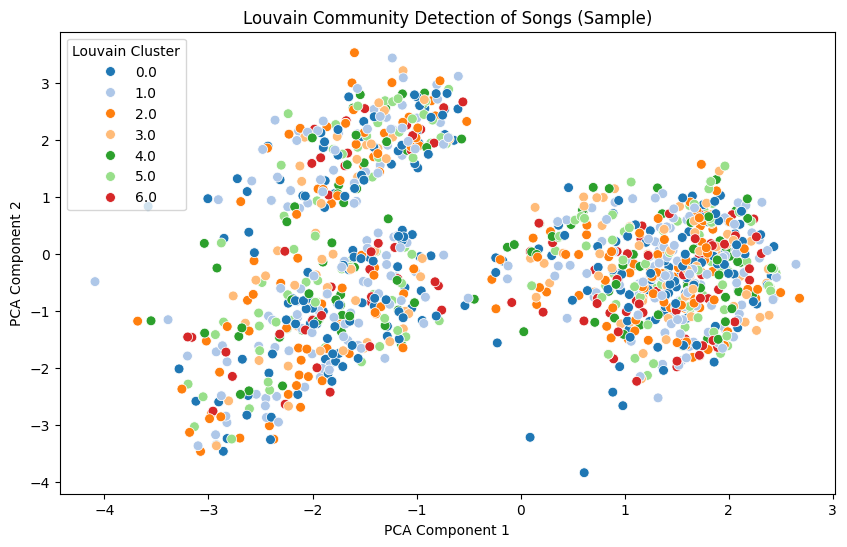

Modularity Score: 0.6274761844138513


In [37]:
import networkx as nx
from community import community_louvain
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Create a sparse similarity graph
def create_sparse_graph(similarity_matrix, threshold=0.2):
    """
    Create a sparse graph from a similarity matrix by thresholding edges.
    """
    similarity_matrix = np.copy(similarity_matrix)  # Avoid modifying the original matrix
    similarity_matrix[similarity_matrix < threshold] = 0  # Set low similarities to 0
    sparse_matrix = csr_matrix(similarity_matrix)  # Convert to sparse format
    return nx.from_scipy_sparse_array(sparse_matrix)  # Use the updated function

# Step 2: Use a reduced graph for Louvain
# Adjust the threshold for sparsity
threshold = 0.8  # Increase threshold for a sparser graph
similarity_graph = create_sparse_graph(similarity_matrix_sample, threshold=threshold)

print(f"Graph Size: {similarity_graph.number_of_nodes()} nodes, {similarity_graph.number_of_edges()} edges")

# Step 3: Perform Louvain Community Detection
# Experiment with resolution for granularity of clusters
resolution = 1
louvain_partition = community_louvain.best_partition(
    similarity_graph, resolution=resolution, random_state=42
)

# Step 4: Add Louvain labels to the DataFrame
X_sample['LouvainCluster'] = X_sample.index.map(louvain_partition)

# Step 5: Analyze Louvain Clusters
print("Louvain Clustering Results:")
print(X_sample['LouvainCluster'].value_counts())

# Step 6: Visualize Louvain Clustering
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample.drop(columns=['LouvainCluster'], errors='ignore'))

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=X_sample['LouvainCluster'], 
    palette="tab20", 
    s=50
)
plt.title("Louvain Community Detection of Songs (Sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Louvain Cluster")
plt.show()


# Step 7: Evaluate Cluster Properties
# Calculate modularity score to assess cluster quality
modularity_score = community_louvain.modularity(louvain_partition, similarity_graph)
print(f"Modularity Score: {modularity_score}")




Louvain Cluster Analysis (Feature Means):
                danceability    energy   valence     tempo  acousticness  \
LouvainCluster                                                             
0.0                -0.112608 -0.216538  0.009474 -0.115092      0.105555   
1.0                -0.313915 -0.070610 -0.065999 -0.040931      0.108394   
2.0                -0.273570 -0.072884 -0.026451 -0.109002      0.059052   
3.0                -0.162435 -0.052657  0.000615  0.010572     -0.050099   
4.0                -0.013099 -0.086766 -0.062811  0.130859      0.004692   
5.0                -0.230925  0.002661  0.008644  0.020622      0.061062   
6.0                -0.238228 -0.089441 -0.042226 -0.176131     -0.005995   

                speechiness_log  instrumentalness_log  liveness_log  \
LouvainCluster                                                        
0.0                    0.075782              0.272894      0.153184   
1.0                    0.085921              0.296992      

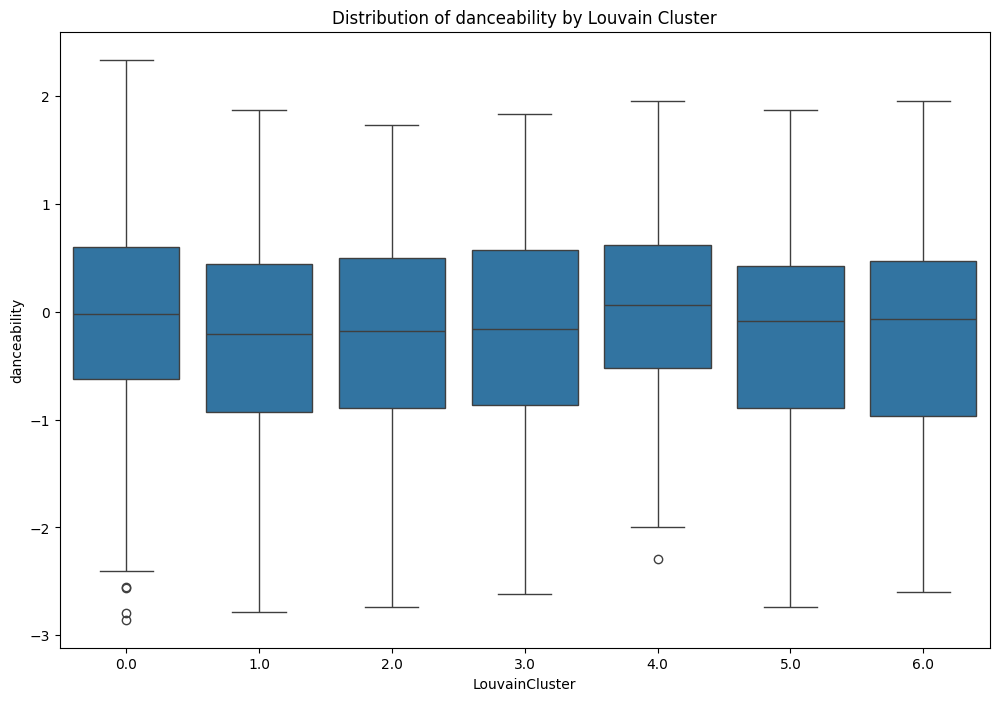

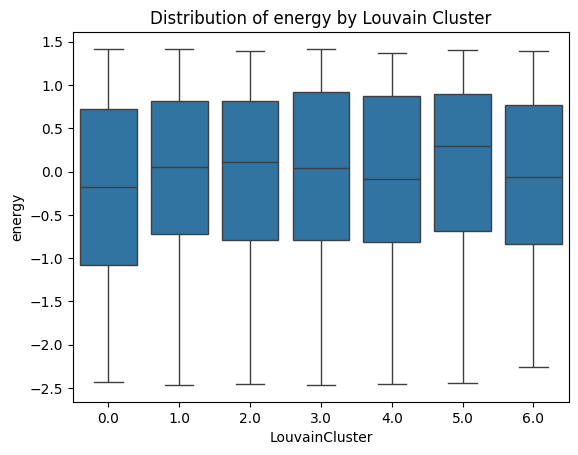

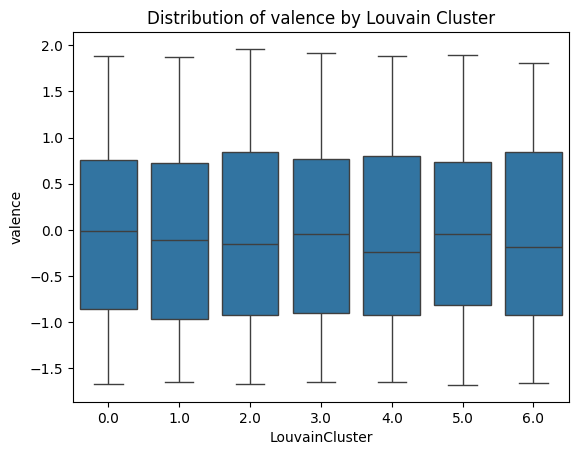

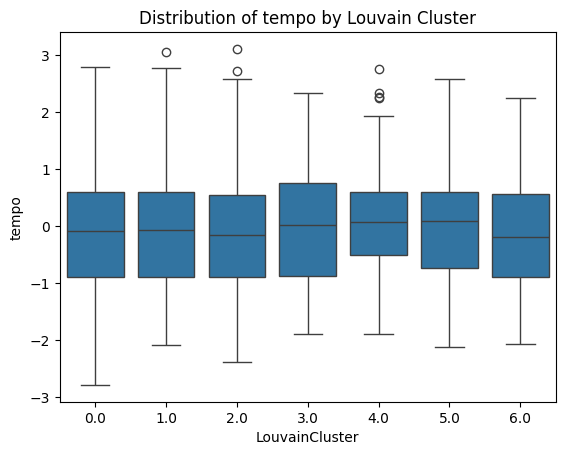

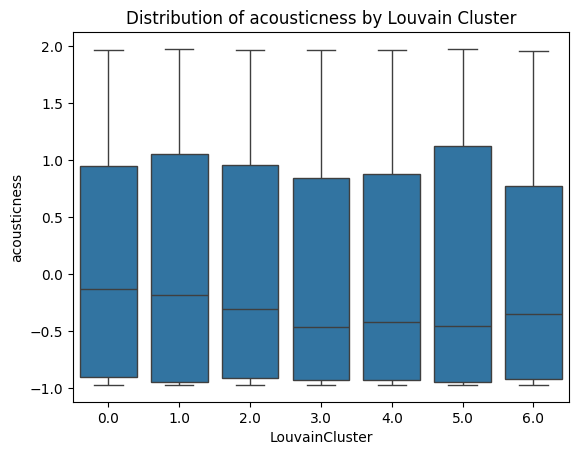

In [38]:
# Step 5: Compare Louvain Clusters with K-Means Clusters
# Assuming you have K-Means cluster labels in `X_sample`
if 'cluster' in X_sample.columns:
    print("\nComparison of Louvain and K-Means Clusters:")
    comparison = pd.crosstab(X_sample['LouvainCluster'], X_sample['cluster'])
    print(comparison)

# Step 6: Analyze Cluster Characteristics
cluster_means = X_sample.groupby('LouvainCluster').mean()
print("\nLouvain Cluster Analysis (Feature Means):")
print(cluster_means)

# Visualize feature distribution by Louvain clusters
plt.figure(figsize=(12, 8))
for feature in ['danceability', 'energy', 'valence', 'tempo', 'acousticness']:
    sns.boxplot(x='LouvainCluster', y=feature, data=X_sample)
    plt.title(f"Distribution of {feature} by Louvain Cluster")
    plt.show()
